In [1]:
%config Completer.use_jedi=False
import itertools as it
from typing import *

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import wandb

sns.set_context("paper", font_scale=1.5)
matplotlib.rc('font', **{'family': 'serif', 'serif': ["Computer modern"]})
matplotlib.rc('text', usetex=True)

In [2]:
def snr(original: np.ndarray, quantised: np.ndarray) -> np.ndarray:
    signal = np.mean(original ** 2, axis=1)
    noise = np.mean((quantised - original) ** 2, axis=1)
    return signal / noise

def round_fpX(a: np.ndarray, exp_min: int, exp_max: int, mantissa_bits: int):
    mantissa_max = 2**mantissa_bits
    absa = np.abs(a)
    loga = np.floor(np.log2(absa))  # note: exponent truncation at an exponent boundary
    basep = 2 ** np.clip(loga, exp_min, exp_max)
    is_normal = (basep <= absa).astype(a.dtype)
    mantissa = np.clip(np.round(mantissa_max * (absa / basep - is_normal)), 0, mantissa_max - 1)
    return np.sign(a) * basep * (is_normal + mantissa / mantissa_max)

FP16 = dict(
    exp_min=-14,
    exp_max=15,
    mantissa_bits=10,
)
FP8_143_GAQ = dict(
    exp_min=-7,
    exp_max=7,
    mantissa_bits=3,
)

In [3]:
# Sanity check

def round_np16(a: np.ndarray):
    return np.clip(a, -65504, 65504).astype(np.float16).astype(np.float64)

test_array = np.random.default_rng(32478323).normal(size=1000) * 2.0 ** np.arange(-28, 28 + 1, step=1)[:, np.newaxis]

# Need a nonzero tolerance here, presumably because our exponent calc doesn't quite round-to-nearest
np.testing.assert_allclose(np.abs(round_np16(test_array) - round_fpX(test_array, **FP16)) / test_array, 0, atol=1e-3)

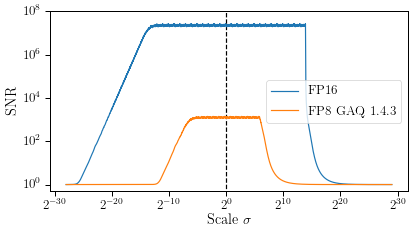

In [6]:
step, samples = 1/128, int(1e3)
# step, samples = 1, 1000

rng = np.random.default_rng(984135)

sigma = 2.0**np.arange(-28, 28 + 1, step=step)
original = rng.normal(size=samples) * sigma[:, np.newaxis]

plt.figure(figsize=(6, 3.5))
ax = plt.gca()
sns.lineplot(x=sigma, y=snr(original, round_fpX(original, exp_min=-14, exp_max=15, mantissa_bits=10)),
             label="FP16")
sns.lineplot(x=sigma, y=snr(original, round_fpX(original, exp_min=-7, exp_max=7, mantissa_bits=3)),
             label="FP8 GAQ 1.4.3")
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10)
ax.set_ylim((5e-1, 1e8))
plt.vlines(1, 0, 1e8, "k", linestyles="dashed")
ax.set_xticks(2.0**np.arange(-30, 31, step=10))
ax.set_yticks(10**np.arange(0, 9, step=2))
ax.set_xlabel("Scale $\sigma$")
ax.set_ylabel("SNR")
plt.legend(loc="center right")
plt.tight_layout()
plt.savefig("out/numerics_basin.pdf");